# Time Series Models from Scratch

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

## Moving Average

In [3]:
class MovingAverage:
    """Simple Moving Average (SMA) model"""

    def __init__(self, window: int):
        self.window = window
        self.history = []

    def fit(self, data: np.ndarray):
        """Store historical data"""
        self.history = list(data)
        return self

    def predict(self, steps: int = 1) -> np.ndarray:
        """Predict next steps using moving average"""
        predictions = []
        temp_history = self.history.copy()

        for _ in range(steps):
            if len(temp_history) < self.window:
                pred = np.mean(temp_history)
            else:
                pred = np.mean(temp_history[-self.window:])
            predictions.append(pred)
            temp_history.append(pred)

        return np.array(predictions)

    def forecast_insample(self) -> np.ndarray:
        """Generate in-sample forecasts"""
        forecasts = []
        for i in range(len(self.history)):
            if i < self.window:
                forecasts.append(np.mean(self.history[:i+1]))
            else:
                forecasts.append(np.mean(self.history[i-self.window:i]))
        return np.array(forecasts)

## Exponential Smoothing

In [4]:
class ExponentialSmoothing:
    """Simple Exponential Smoothing (SES) model"""

    def __init__(self, alpha: float = 0.3):
        self.alpha = alpha
        self.history = []
        self.level = None

    def fit(self, data: np.ndarray):
        """Fit exponential smoothing model"""
        self.history = list(data)
        self.level = data[0]

        # Update level through all data
        for val in data[1:]:
            self.level = self.alpha * val + (1 - self.alpha) * self.level

        return self

    def predict(self, steps: int = 1) -> np.ndarray:
        """Predict next steps (flat forecast)"""
        return np.array([self.level] * steps)

    def forecast_insample(self) -> np.ndarray:
        """Generate in-sample forecasts"""
        forecasts = [self.history[0]]
        level = self.history[0]

        for i in range(1, len(self.history)):
            forecasts.append(level)
            level = self.alpha * self.history[i] + (1 - self.alpha) * level

        return np.array(forecasts)

## Holt-Winters

In [5]:
class HoltWinters:
    """Holt-Winters Exponential Smoothing (with trend)"""

    def __init__(self, alpha: float = 0.3, beta: float = 0.1):
        self.alpha = alpha  # Level smoothing
        self.beta = beta    # Trend smoothing
        self.level = None
        self.trend = None
        self.history = []

    def fit(self, data: np.ndarray):
        """Fit Holt-Winters model"""
        self.history = list(data)

        # Initialize level and trend
        self.level = data[0]
        self.trend = data[1] - data[0] if len(data) > 1 else 0

        # Update level and trend through all data
        for val in data[1:]:
            prev_level = self.level
            self.level = self.alpha * val + (1 - self.alpha) * (self.level + self.trend)
            self.trend = self.beta * (self.level - prev_level) + (1 - self.beta) * self.trend

        return self

    def predict(self, steps: int = 1) -> np.ndarray:
        """Predict next steps with trend"""
        predictions = []
        for h in range(1, steps + 1):
            predictions.append(self.level + h * self.trend)
        return np.array(predictions)

    def forecast_insample(self) -> np.ndarray:
        """Generate in-sample forecasts"""
        forecasts = [self.history[0]]
        level = self.history[0]
        trend = self.history[1] - self.history[0] if len(self.history) > 1 else 0

        for i in range(1, len(self.history)):
            forecasts.append(level + trend)
            prev_level = level
            level = self.alpha * self.history[i] + (1 - self.alpha) * (level + trend)
            trend = self.beta * (level - prev_level) + (1 - self.beta) * trend

        return np.array(forecasts)


## ARIMA

In [15]:
class ARIMA:
    """ARIMA(p, d, q) model implemented from scratch"""

    def __init__(self, p: int = 1, d: int = 0, q: int = 1):
        self.p = p  # AR order
        self.d = d  # Differencing order
        self.q = q  # MA order
        self.ar_params = None
        self.ma_params = None
        self.const = None
        self.history = []
        self.residuals = []
        self.original_data = []

    def difference(self, data: np.ndarray, order: int = 1) -> np.ndarray:
        """Apply differencing to data"""
        result = data.copy()
        for _ in range(order):
            result = np.diff(result)
        return result

    def inverse_difference(self, diff_data: np.ndarray, initial_values: list) -> np.ndarray:
        """Reverse differencing operation"""
        result = diff_data.copy()
        for init_val in reversed(initial_values):
            result = np.cumsum(np.concatenate([[init_val], result]))[1:]
        return result

    def fit(self, data: np.ndarray, learning_rate: float = 0.01, epochs: int = 100):
        """Fit ARIMA model using simple gradient descent"""
        self.original_data = data.copy()

        # Apply differencing
        diff_data = self.difference(data, self.d)
        self.history = list(diff_data)

        # Initialize parameters
        self.ar_params = np.random.randn(self.p) * 0.1
        self.ma_params = np.random.randn(self.q) * 0.1
        self.const = np.mean(diff_data)

        # Simple training loop
        for epoch in range(epochs):
            errors = []

            for t in range(max(self.p, self.q), len(diff_data)):
                # AR component
                ar_component = sum(self.ar_params[i] * diff_data[t-i-1]
                                 for i in range(self.p))

                # MA component (using past errors)
                ma_component = 0
                if len(errors) >= self.q:
                    ma_component = sum(self.ma_params[i] * errors[-(i+1)]
                                     for i in range(self.q))

                # Prediction
                pred = self.const + ar_component + ma_component
                error = diff_data[t] - pred
                errors.append(error)

            # Store residuals from last epoch
            if epoch == epochs - 1:
                self.residuals = errors

        return self

    def predict(self, steps: int = 1) -> np.ndarray:
        """Predict next steps"""
        predictions = []
        temp_history = self.history.copy()
        temp_residuals = self.residuals.copy() if self.residuals else [0] * self.q

        for _ in range(steps):
            # AR component
            ar_component = sum(self.ar_params[i] * temp_history[-(i+1)]
                             for i in range(min(self.p, len(temp_history))))

            # MA component
            ma_component = sum(self.ma_params[i] * temp_residuals[-(i+1)]
                             for i in range(min(self.q, len(temp_residuals))))

            pred = self.const + ar_component + ma_component
            predictions.append(pred)
            temp_history.append(pred)
            temp_residuals.append(0)  # Assume zero future errors

        # Reverse differencing if needed
        if self.d > 0:
            initial_vals = [self.original_data[-(i+1)] for i in range(self.d)]
            predictions = self.inverse_difference(np.array(predictions), initial_vals)

        return np.array(predictions)


## Demonstration

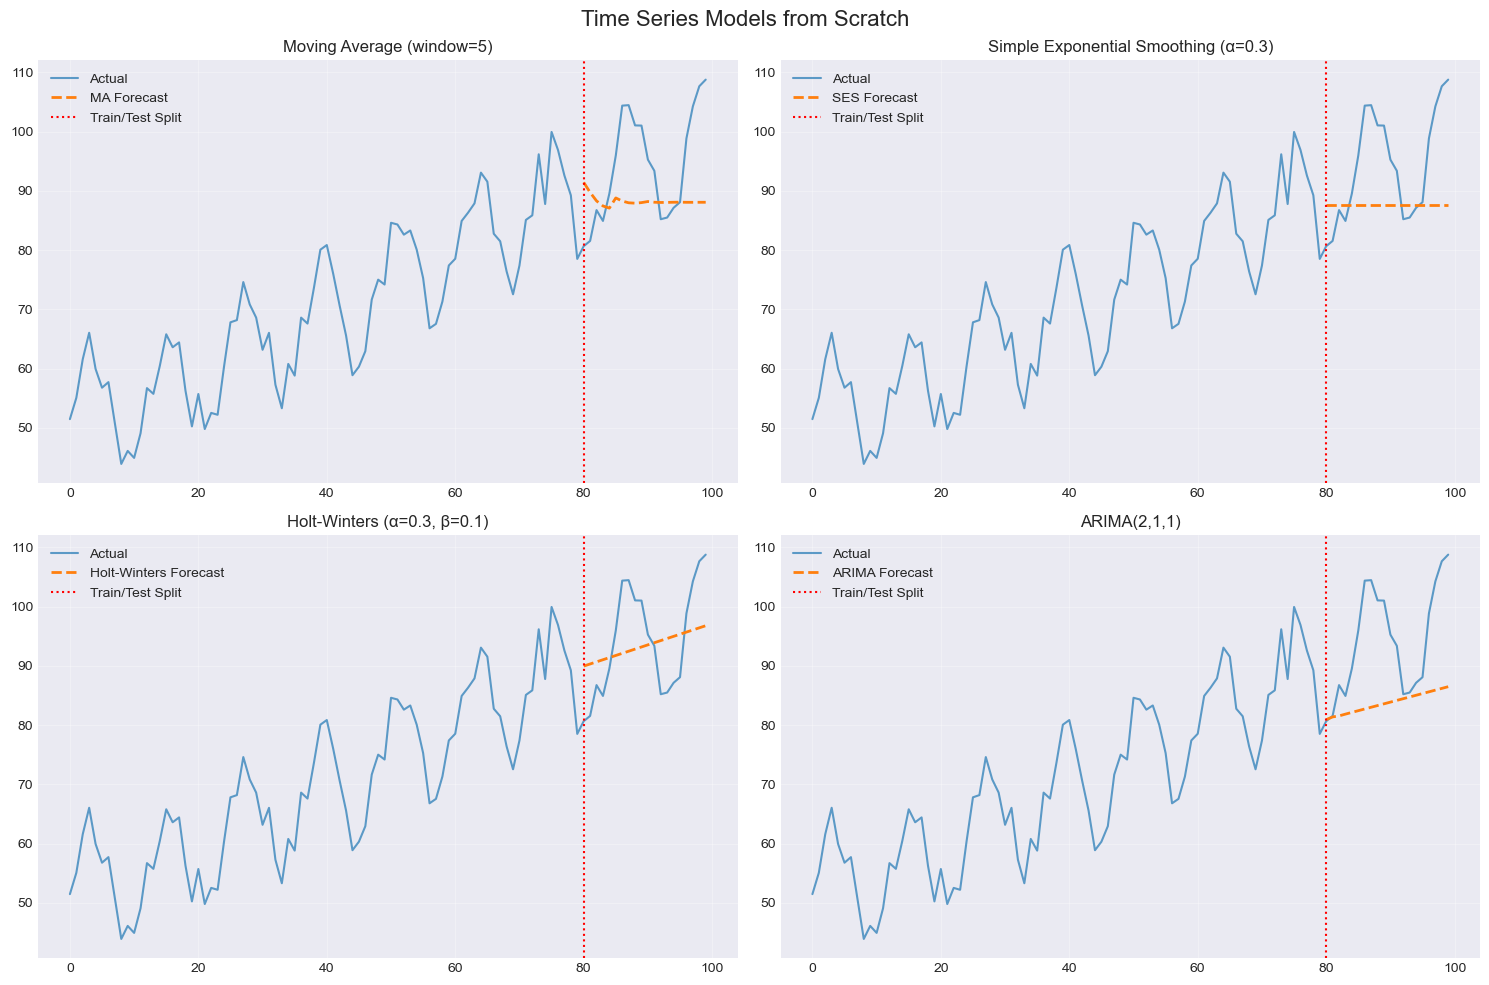


Mean Squared Error (MSE) on Test Set:
Moving Average: 120.32
Simple Exponential Smoothing: 121.67
Holt-Winters: 64.54
ARIMA: 176.02


In [34]:
# Generate synthetic time series data
np.random.seed(42)
t = np.arange(100)
trend = 0.5 * t
seasonal = 10 * np.sin(2 * np.pi * t / 12)
noise = np.random.randn(100) * 3
data = 50 + trend + seasonal + noise

# Split into train and test
train_size = 80
train_data = data[:train_size]
test_data = data[train_size:]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Series Models from Scratch', fontsize=16)

# 1. Moving Average
ma = MovingAverage(window=5)
ma.fit(train_data)
ma_forecast = ma.predict(len(test_data))

axes[0, 0].plot(data, label='Actual', alpha=0.7)
axes[0, 0].plot(range(train_size, len(data)), ma_forecast,
                label='MA Forecast', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=train_size, color='red', linestyle=':', label='Train/Test Split')
axes[0, 0].set_title('Moving Average (window=5)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Exponential Smoothing
ses = ExponentialSmoothing(alpha=0.3)
ses.fit(train_data)
ses_forecast = ses.predict(len(test_data))

axes[0, 1].plot(data, label='Actual', alpha=0.7)
axes[0, 1].plot(range(train_size, len(data)), ses_forecast,
                label='SES Forecast', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=train_size, color='red', linestyle=':', label='Train/Test Split')
axes[0, 1].set_title('Simple Exponential Smoothing (α=0.3)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Holt-Winters
hw = HoltWinters(alpha=0.3, beta=0.1)
hw.fit(train_data)
hw_forecast = hw.predict(len(test_data))

axes[1, 0].plot(data, label='Actual', alpha=0.7)
axes[1, 0].plot(range(train_size, len(data)), hw_forecast,label='Holt-Winters Forecast', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=train_size, color='red', linestyle=':', label='Train/Test Split')
axes[1, 0].set_title('Holt-Winters (α=0.3, β=0.1)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. ARIMA
arima = ARIMA(p=2, d=1, q=1)
arima.fit(train_data, learning_rate=0.01, epochs=50)
arima_forecast = arima.predict(len(test_data))

axes[1, 1].plot(data, label='Actual', alpha=0.7)
axes[1, 1].plot(range(train_size, len(data)), arima_forecast,label='ARIMA Forecast', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=train_size, color='red', linestyle=':', label='Train/Test Split')
axes[1, 1].set_title('ARIMA(2,1,1)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print errors
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

print("\nMean Squared Error (MSE) on Test Set:")
print(f"Moving Average: {mse(test_data, ma_forecast):.2f}")
print(f"Simple Exponential Smoothing: {mse(test_data, ses_forecast):.2f}")
print(f"Holt-Winters: {mse(test_data, hw_forecast):.2f}")
print(f"ARIMA: {mse(test_data, arima_forecast):.2f}")